# Glutamine Synthetase Inhibition through End Products of Glutamine Metabolism

### BME 3990 Final Project by Eamon, Julia, and Shannon

This notebook uses the CSB2 environment and will be incorporating bits of code from previous notebooks in this class. 

### Introduction:

Glutamine is an amino acid primarily used in protein biosynthesis. Glutamine is heavily involved in cell metabolism, supplementing the citric acid cycle and serving as a precursor to several nonessential amino acids, nucleotides, and other important biomolecules. The enzyme glutamine synthetase catalyzes the condensation of glutamate and ammonia to form glutamine. Glutamine synthetase is regulated through end product inhibition by nine end products of glutamine that allosterically bind to different sites on the enzyme to almost entirely inhibit activity. Our project aims to investigate the mechanisms of glutamine synthetase while incorporating Michaelis-Menten kinetics of glutamine synthetase to gain a larger scope of the synthesis of glutamine with glutamine synthetase.


In [3]:
#Imports  
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Michaelis-Menten Kinetics without Inhibition for Glutamine Synthetase:

Initially, we are going to model Michaelis-Menten kinetics for glutamine synthetase using K_cat and K_M values from BRENDA. As we learned in class, the equation for Michaelis-Menten is $V = V_{max}\frac{[A]}{K_{M}+[A]}$ and $V_{max} = K_{cat}*[E]_{0}$. In those equations, V: reaction rate, Km: Michaelis constant, A: concentration of reactant, Vmax: maximum reaction rate, K_cat: catalytic constant & E_0: initial enzyme concentration. 

In [38]:
#Modeling Michaelis-Menten kinetics for Glutamine Synthetase
#Variables imported from BRENDA
K_cat = 2580
K_M = 3
E_0 = 10e-3
#Range of reactant concentrations
A = np.linspace(0,1000,1000)
#Calculate rate from MM equation
v = K_cat * E_0 * (A/(K_M+A))
V_max = K_cat * E_0

Text(0.5, 1.0, 'Michaelis Menten Kinetics - Glutamine Synthetase without Inhibition')

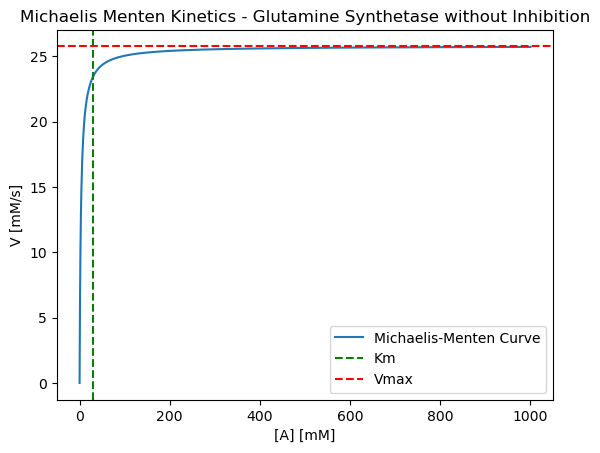

In [44]:
#Plot V vs A
plt.plot(A,v,label ='Michaelis-Menten Curve')
plt.xlabel('[A] [mM]')
plt.ylabel('V [mM/s]')
#Plot Km and vmax
plt.axvline(x =K_M, color ='g',linestyle ='--',label='Km')
plt.axhline(y = V_max, color ='r',linestyle ='--',label='Vmax')
plt.legend()
plt.title('Michaelis Menten Kinetics - Glutamine Synthetase without Inhibition')

### Modeling Concentration vs. Time of Glutamine Synthetase:

Next, we are going to model concentration (in mM) vs. time (in seconds) of glutamine synthetase to understand how the reaction progresses over time. 

In [41]:
#Variables imported from BRENDA
K_cat = 2580
K_M = 30
E_0 = 10e-3
#Function for ODE (y[1] = A reactant) 
def MM_dynamics(t,y,K_cat,K_M,E_0):
    dydt = np.zeros(2)
    v = K_cat*E_0*(y[1]/(K_M+y[1]))
    dydt[0] = v
    dydt[1] = -v
    return dydt

In [42]:
#Initial Conditions
y0 = [0,100]
#Time span
t = np.linspace(0,10,100)
tspan = [t[0],t[-1]]
#Call function
ode_sol = solve_ivp(lambda t,y:MM_dynamics(t,y,K_cat,K_M,E_0),tspan,y0,t_eval=t)

Text(0.5, 1.0, 'mM vs time - Glutamine Synthetase')

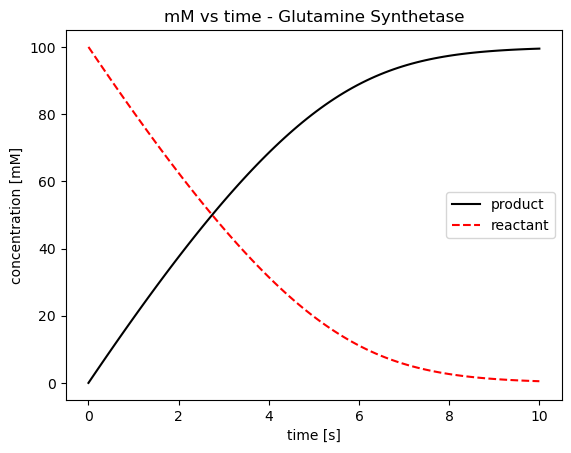

In [43]:
#Plot results
plt.plot(t,ode_sol.y[0],'k-')
plt.plot(t,ode_sol.y[1],'r--')
#Annotate graph
plt.xlabel('time [s]')
plt.ylabel('concentration [mM]')
plt.legend(['product','reactant'])
plt.title('mM vs time - Glutamine Synthetase')

### Modeling Individual Inhibitors Concentration over Time:

For further analysis, our group is going to explore the nine inhibiors: alanine, serine, tryptophan, histidine, glycine, glucosamine-6-phosphate, carbamoyl phosphate, AMP, and CTP. We looked at multiple sources to create this inhibition model and calculated abundances and KI values relative to inhibitor potency, as more potent inhibitors will have an increased effect on the kinetics of the enzyme. 

In [45]:
#Created parameters for inhibitors relative to inhibitor potency
abundances = {
    'Alanine': 0.161,
    'Serine': 0.111,
    'Tryptophan': 0.041,
    'Histidine': 0.046,
    'Glycine': 0.198,
    'Glucosamine-6-Phosphate': 0.074,
    'Carbamoyl Phosphate': 0.106,
    'AMP': 0.171,
    'CTP': 0.092}

Ki_values = {
    'Alanine': 16.1,  
    'Serine': 11.1,
    'Tryptophan': 4.1,
    'Histidine': 4.6,
    'Glycine': 19.8,
    'Glucosamine-6-Phosphate': 7.4,
    'Carbamoyl Phosphate': 10.6,
    'AMP': 17.1,
    'CTP': 9.2}

#Use function to add inhibitor concentrations to the ODE system
def MM_dynamics_with_inhibitors(t, y, K_cat, K_M, E_0, Ki_values, abundances):
    dydt = np.zeros(2)
    v = K_cat * E_0 * (y[1] / (K_M + y[1]))
    
    #Calculate total inhibition based on all inhibitors
    total_inhibition = 1
    #Gtab abundance in abundances for each inhibitor
    Ki = Ki_values.get(inhibitor) 
    total_inhibition *= 1 + (Ki * abundance)
    #Fraction of v over total inhibition
    v_inhibited = v / total_inhibition
    #Create project and reactant variables
    dydt[0] = v_inhibited  
    dydt[1] = -v_inhibited 
    return dydt


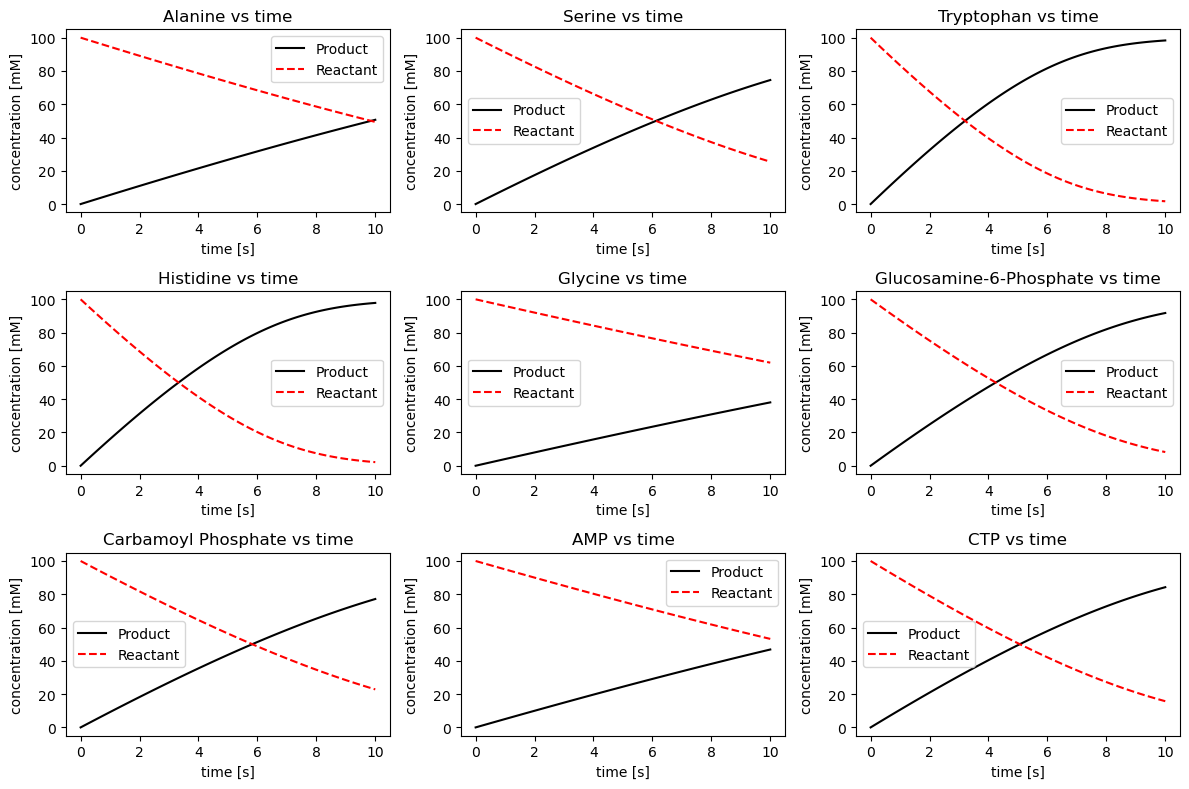

In [46]:
#Plot all inhibitors in a subplot
[fig,axs] = plt.subplots(3,3,figsize=[12,8])
axs = axs.flatten()

#Loop through each inhibitor and plot its concentration over time
for i, (inhibitor, abundance) in enumerate(abundances.items()):
    #Solve the ODE for the current inhibitor
    ode_sol_inhibited = solve_ivp(
        lambda t, y: MM_dynamics_with_inhibitors(t, y, K_cat, K_M, E_0, Ki_values, {inhibitor: abundance}),
        tspan, y0, t_eval=t
    )
    
    #Plot the results and label lines
    axs[i].plot(t, ode_sol_inhibited.y[0], 'k-', label='Product')
    axs[i].plot(t, ode_sol_inhibited.y[1], 'r--', label='Reactant')
    axs[i].set_xlabel('time [s]')
    axs[i].set_ylabel('concentration [mM]')
    axs[i].legend()
    axs[i].set_title(inhibitor + ' vs time')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Modeling Michaelis-Menten Kinetics for each Inhibitor: 

Using the same formulas for Michaelis-Menten kinetics as above, we will model each individual inhibitor to have a closer look at how the enzyme is affected when inhibited. 

In [47]:
#Modeling Michaelis-Menten kinetics for each inhibitor
#Initial constants calculated off inhibitor potency from BRENDA Kcat value
Kcat_values = {
    'Alanine': 2580 * .161,  
    'Serine': 2580 * .111,
    'Tryptophan': 2580 * .041,
    'Histidine': 2580 * .046,
    'Glycine': 2580 * .198,
    'Glucosamine-6-Phosphate': 2580 * .074,
    'Carbamoyl Phosphate': 2580 * .106,
    'AMP': 2580 * .171,
    'CTP': 2580 * .092}

K_M = 3
E_0 = 10e-3
#Range of reactant concentrations
A = np.linspace(0,500,1000)


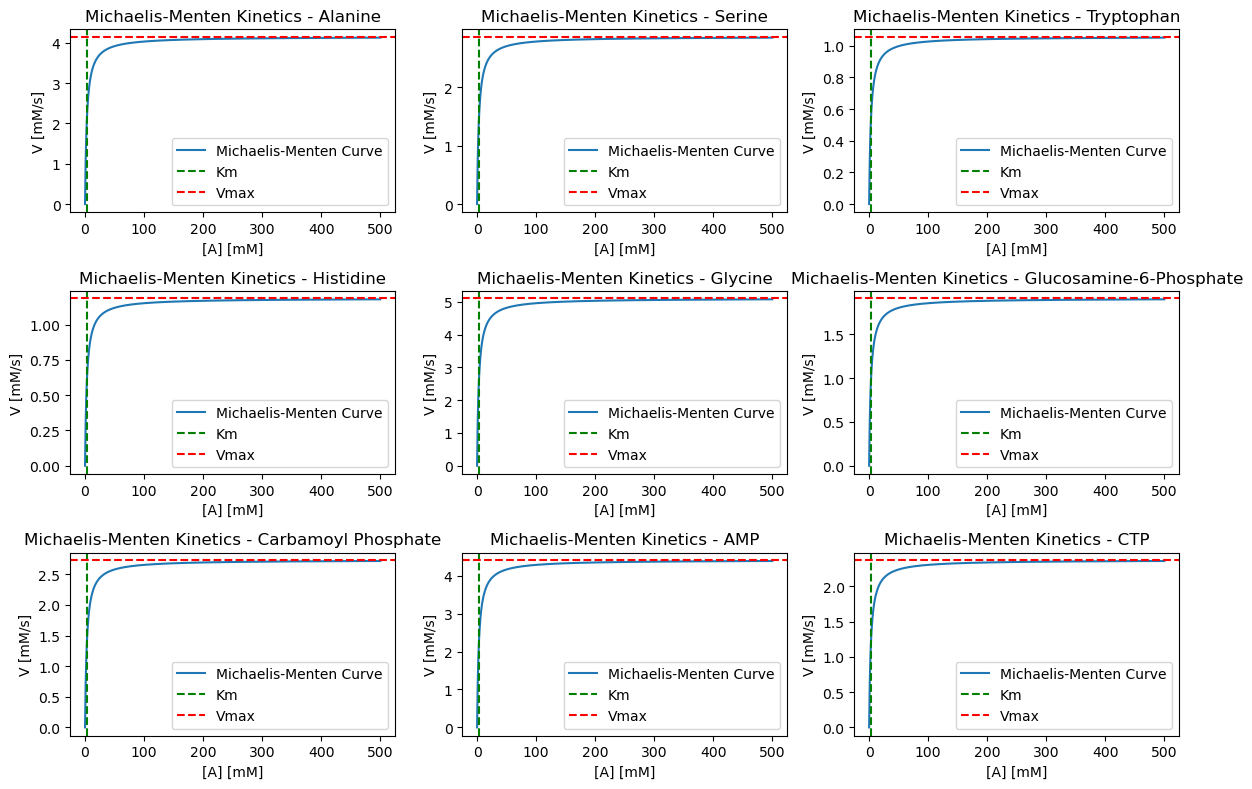

In [48]:
#Initialize subplots Michaelis Menten kinetics 
fig, axs = plt.subplots(3, 3, figsize=[12, 8])
axs = axs.flatten()

#Loop through each inhibitor and plot its Michaelis-Menten kinetics
for i, (inhibitor, Kcat) in enumerate(Kcat_values.items()):
    #Calculate rate from MM equation
    v = Kcat * E_0 * (A / (K_M + A))
    V_max = Kcat * E_0
    
    #Plot V vs A in loop to add separate subplots
    axs[i].plot(A, v, label='Michaelis-Menten Curve')
    axs[i].axvline(x=K_M, color='g', linestyle='--', label='Km')
    axs[i].axhline(y=V_max, color='r', linestyle='--', label='Vmax')
    axs[i].legend()
    axs[i].set_xlabel('[A] [mM]')
    axs[i].set_ylabel('V [mM/s]')
    axs[i].set_title('Michaelis-Menten Kinetics - ' + inhibitor)

plt.tight_layout()
plt.show()


### Collective Inhibition: 

Next, our group plans to show the Michaelis-Menten kinetics of each inhibitor but all on the same graph this time. We had to ensure to use the maximum values of Kcat to calculate Vmax as the code automatically picks the last value instead of the largest. 

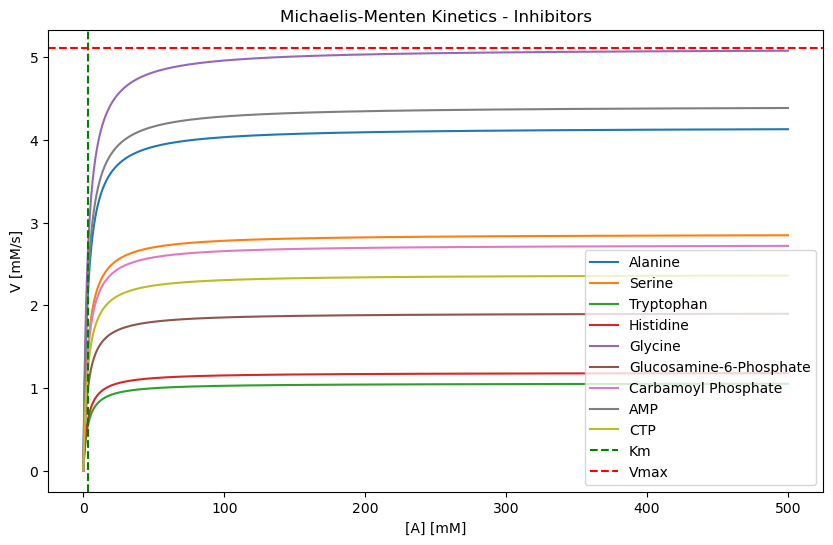

In [49]:
#Now all together 
#Plot all inhibitor Michaelis-Menten kinetics on one graph
plt.figure(figsize=(10, 6))

#loop through to plot and calculate v
for inhibitor, Kcat in Kcat_values.items():
    # Calculate rate from MM equation
    v = Kcat * E_0 * (A / (K_M + A))
    
    
    # Plot V vs A for each inhibitor
    plt.plot(A, v, label=inhibitor)

    
#Calculate maximum Vmax value among all inhibitors
V_max_values = [Kcat * E_0 for Kcat in Kcat_values.values()]
V_max = max(V_max_values) 

#Plot Km and Vmax lines
plt.axvline(x=K_M, color='g', linestyle='--', label='Km')
plt.axhline(y=V_max, color='r', linestyle='--', label='Vmax')
#Annotate
plt.xlabel('[A] [mM]')
plt.ylabel('V [mM/s]')
plt.legend()
plt.title('Michaelis-Menten Kinetics - Inhibitors')
plt.show()

### Combined Inhibitor Kinetics:

We wanted to use random concentrations of inhibitor and calculate Km and Vmax to see how they change as the inhibitor concentration changes. 

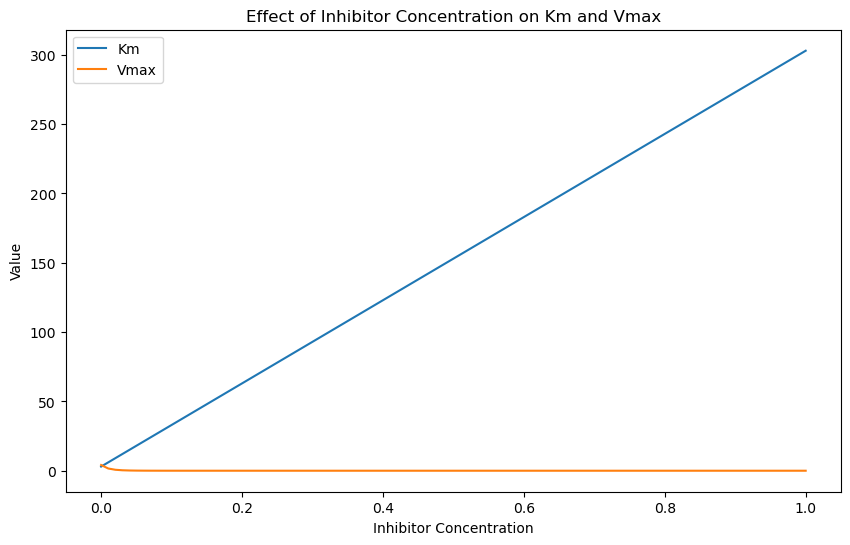

In [50]:
#Plotting combined inhibitor kinetics
plt.figure(figsize=(10, 6))

#random concentrations of inhibitor
inhibitor_concentrations = {
    'Alanine': 0.85,
    'Serine': 0.3,
    'Tryptophan': 0.2,
    'Histidine': 0.1,
    'Glycine': 0.8,
    'Glucosamine-6-Phosphate': 0.8,
    'Carbamoyl Phosphate': 0.7,
    'AMP': 0.9,
    'CTP': 0.12}


#Calculating and plotting Km and Vmax with varying inhibitor concentrations
inhibitor_concentrations = np.linspace(0, 1, 100)
Km_values = []
Vmax_values = []

for concentration in inhibitor_concentrations:
    inhibitor_concentration = {inhibitor: concentration for inhibitor in Kcat_values.keys()}
    rate = calculate_rate_with_inhibition(A, inhibitor_concentration)
    
    # Calculate Km and Vmax
    Km = K_M * (1 + sum([Ki * concentration for Ki in Ki_values.values()]))
    Vmax = max(rate)
    Km_values.append(Km)
    Vmax_values.append(Vmax)

plt.plot(inhibitor_concentrations, Km_values, label='Km')
plt.plot(inhibitor_concentrations, Vmax_values, label='Vmax')

plt.xlabel('Inhibitor Concentration')
plt.ylabel('Value')
plt.legend()
plt.title('Effect of Inhibitor Concentration on Km and Vmax')
plt.show()

